In [2]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, Audio
import librosa.feature as ft
import wave
import struct
import librosa
import time
import librosa.display
from os import listdir
from os.path import isfile, join
import scipy.io

In [3]:
def remove_init_noise(sig, fs, method="mean", ratio_parameter = 6, len_noise = 1000) :
    """
    Renvoie le signal tronqué avec le vecteurs temps associé

    # Inputs
    - sig : signal audio à tronquer
    - fs : fréquence d'échantillonnage (utile pour regénérer le vecteur temps)
    - ratio_parameter : paramètre à adapter pour couper plus ou moins le bruit. 6 par défaut

    # Ouputs
    - time : nouveau vecteur temps
    - sig : nouveau signal audio tronqué
    """
    sig /= np.max(np.abs(sig))
    noise = sig[:len_noise]
    if method == "mean" :
        noise_threshold = np.mean(np.abs(noise))
    elif method == "max" :
        noise_threshold = np.max(np.abs(noise))

    i=0
    while np.abs(sig[i]) < ratio_parameter*noise_threshold :
        i += 1
    #i correspond au premier indice au dessus du seuil
    sig = sig[i:]
    time = np.arange(len(sig))/fs
    return time, sig

def spectral_slope(data, sr, n_fft=2048, hop_length=None, win_length=None, 
                   window='hann', center=True, pad_mode='constant'):

    S, phase = librosa.magphase(librosa.stft(y=data, n_fft=n_fft, hop_length=hop_length, win_length=win_length, window=window, 
                                             center=center, pad_mode=pad_mode))
    slope = np.zeros((1,S.shape[1]))
    freq = librosa.fft_frequencies(sr=sr, n_fft=n_fft)
    for k in range(S.shape[1]):
        fit = np.polyfit(freq, S[:,k], 1)
        slope[0,k] =fit[0]
    return slope

def compute_features(data, sr, S=None, n_fft=2048, frame_length=2048, hop_length=512, win_length=None, window='hann',
                     center=True, pad_mode='constant', freq=None, fmin=200.0, n_bands=6, quantile=0.02, linear=False, centroid=None, norm=True,
                     p=2, amin=1e-10, power=2.0,roll_percent=0.85):
    
    
    cent = librosa.feature.spectral_centroid(y=data, sr=sr, S=S, n_fft=n_fft, hop_length=hop_length, freq = freq,
                                             win_length=win_length, window=window, center=center, pad_mode=pad_mode)
    spec_bw = librosa.feature.spectral_bandwidth(y=data, sr=sr, S=S, n_fft=n_fft, hop_length=hop_length, win_length=win_length, window=window, 
                                                 center=center, pad_mode=pad_mode, freq=freq, centroid=centroid, norm=norm, p=p)
    contrast = librosa.feature.spectral_contrast(y=data, sr=sr, S=S, n_fft=n_fft, hop_length=hop_length, win_length=win_length, window=window, center=center,
                                                 pad_mode=pad_mode, freq=freq, fmin=fmin, n_bands=n_bands, quantile=quantile, linear=linear)
    
    flatness = librosa.feature.spectral_flatness(y=data, S=S, n_fft=n_fft, hop_length=hop_length, win_length=win_length, window=window, center=center,
                                                 pad_mode=pad_mode, amin=amin, power=power)
    
    rolloff = librosa.feature.spectral_rolloff(y=data, sr=sr, S=S, n_fft=n_fft, hop_length=hop_length, win_length=win_length, window=window, 
                                                center=center, pad_mode=pad_mode, freq=freq, roll_percent=roll_percent)
    zcr = librosa.feature.zero_crossing_rate(y=data, frame_length=frame_length, hop_length=hop_length, center=center)
    
    rms = librosa.feature.rms(y=data, S=S, frame_length=frame_length, hop_length=hop_length, center=center, pad_mode=pad_mode)
    
    slope = spectral_slope(data, sr, n_fft=n_fft, hop_length=hop_length, win_length=win_length, 
                   window=window, center=center, pad_mode=pad_mode)
    
    dict_features = {}
    dict_features['spectral_centroid'] = cent
    dict_features['spectral_bandwidth'] = spec_bw
    dict_features['spectral_contrast'] = contrast
    dict_features['spectral_flatness'] = flatness
    dict_features['spectral_rolloff'] = rolloff
    dict_features['zero_crossing_rate'] = zcr
    dict_features['rms'] = rms
    dict_features['spectral_slope'] = slope
    
    return dict_features

In [4]:
monRepertoire_experience = '../../Mesures/Mesures_2023.01.27_LAM_normalise/'
fichiers_table = [f for f in listdir(monRepertoire_experience) if not isfile(join(monRepertoire_experience, f))]
data_experience = {}
for matiere in fichiers_table:
    fichiers_corde = [f for f in listdir(monRepertoire_experience+matiere) if not isfile(join(monRepertoire_experience+matiere, f))]
    for corde in fichiers_corde:
        fichiers_mat = [f for f in listdir(monRepertoire_experience+matiere+'/'+corde) if (isfile(join(monRepertoire_experience+matiere+'/'+corde, f) ))]
        for mat in fichiers_mat:
            if mat != ".DS_Store":
                sig = scipy.io.loadmat(monRepertoire_experience+matiere+'/'+corde+'/'+mat)['acc_t']
                fs = scipy.io.loadmat(monRepertoire_experience+matiere+'/'+corde+'/'+mat)['fs'][0][0]
                time, wav = remove_init_noise(sig, fs, method="mean", ratio_parameter = 6, len_noise = 10000)
                wav = wav[:int(fs*3)]
                data_experience[matiere+'_'+corde+'_'+mat] = {}
                data_experience[matiere+'_'+corde+'_'+mat]['data'] = wav
                data_experience[matiere+'_'+corde+'_'+mat]['table_matiere'] = matiere
                data_experience[matiere+'_'+corde+'_'+mat]['corde_matiere'] = corde
                data_experience[matiere+'_'+corde+'_'+mat]['corde_plectre'] = mat
                data_experience[matiere+'_'+corde+'_'+mat]['Fe'] = fs
                
                if matiere == 'Metal':
                    data_experience[matiere+'_'+corde+'_'+mat]['rho_table'] = 2700
                if matiere == 'Plexi':
                    data_experience[matiere+'_'+corde+'_'+mat]['rho_table'] = 1180
                if matiere == 'Medium_1':
                    data_experience[matiere+'_'+corde+'_'+mat]['rho_table'] = 600
                if matiere == 'Medium_2':
                    data_experience[matiere+'_'+corde+'_'+mat]['rho_table'] = 800
                
                if 'C_1' in mat:
                    data_experience[matiere+'_'+corde+'_'+mat]['corde_numero'] = 1
                if 'C_2' in mat:
                    data_experience[matiere+'_'+corde+'_'+mat]['corde_numero'] = 2
                if 'C_3' in mat:
                    data_experience[matiere+'_'+corde+'_'+mat]['corde_numero'] = 3
                if 'C_4' in mat:
                    data_experience[matiere+'_'+corde+'_'+mat]['corde_numero'] = 4
                if 'C_5' in mat:
                    data_experience[matiere+'_'+corde+'_'+mat]['corde_numero'] = 5
                if 'C_6' in mat:
                    data_experience[matiere+'_'+corde+'_'+mat]['corde_numero'] = 6
                    
                if 'P_1' in mat:
                    data_experience[matiere+'_'+corde+'_'+mat]['plectre_numero'] = 1
                if 'P_2' in mat:
                    data_experience[matiere+'_'+corde+'_'+mat]['plectre_numero'] = 2
                if 'P_3' in mat:
                    data_experience[matiere+'_'+corde+'_'+mat]['plectre_numero'] = 3
                if 'P_4' in mat:
                    data_experience[matiere+'_'+corde+'_'+mat]['plectre_numero'] = 4

c:\users\ulysse\appdata\local\programs\python\python39\lib\site-packages\scipy\io\matlab\mio.py:224: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)


In [5]:
all_cle_exp = list(data_experience.keys())

Medium_1_Corde_Acier_C_2_P_1.mat


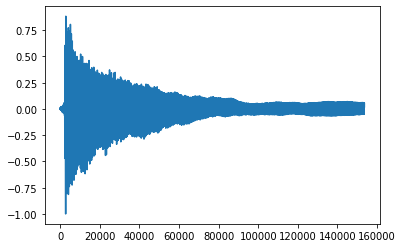

In [12]:
x_exp = data_experience[all_cle_exp[3]]['data']
Fe_exp = data_experience[all_cle_exp[0]]['Fe']
print(all_cle_exp[3])
t_exp = np.linspace(0,3, len(x_exp))
plt.figure()
plt.plot(x_exp)

In [13]:
display(Audio(x_exp.T, rate=Fe_exp))

In [8]:
M_before_exp = np.zeros((len(x_exp), len(data_experience.keys())))
x_axis_exp = np.zeros(len(data_experience.keys()))
corde_numero_exp = np.zeros(len(data_experience.keys()))
i=0
for cle in all_cle_exp:
    M_before_exp[:,i] = np.reshape(data_experience[cle]['data'][:len(x_exp)],(len(x_exp)))
    x_axis_exp[i] = data_experience[cle]['rho_table']
    corde_numero_exp[i] = data_experience[cle]['corde_numero']
    i+=1

inds_exp = x_axis_exp.argsort()
x_axis_exp = np.take_along_axis(x_axis_exp, inds_exp, axis=0)
M_exp=np.zeros((len(x_exp), len(data_experience.keys())))
for k in range(len(inds_exp)):
    M_exp[:,k] = M_before_exp[:,inds_exp[k]]

In [13]:
data_features_exp={}
for k in range(len(data_experience.keys())):
    data_features_exp[all_cle_exp[k]] = compute_features(M_exp[:,k], sr=Fe_exp, S=None, n_fft=2048, hop_length=256, win_length=None, window='hann',
                     center=True, pad_mode='constant', freq=None, fmin=200.0, n_bands=6, quantile=0.02, linear=False, centroid=None, norm=True,
                     p=2, amin=1e-10, power=2.0,roll_percent=0.85)

In [22]:
#Ou commencer et finir la visualtion
debut = 0
fin = -10

In [25]:
(len(data_features_exp[all_cle_exp[0]]['spectral_bandwidth'][0]))

601

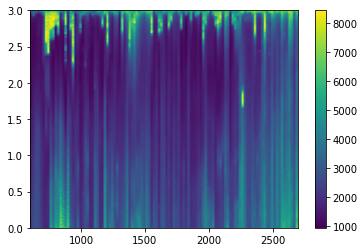

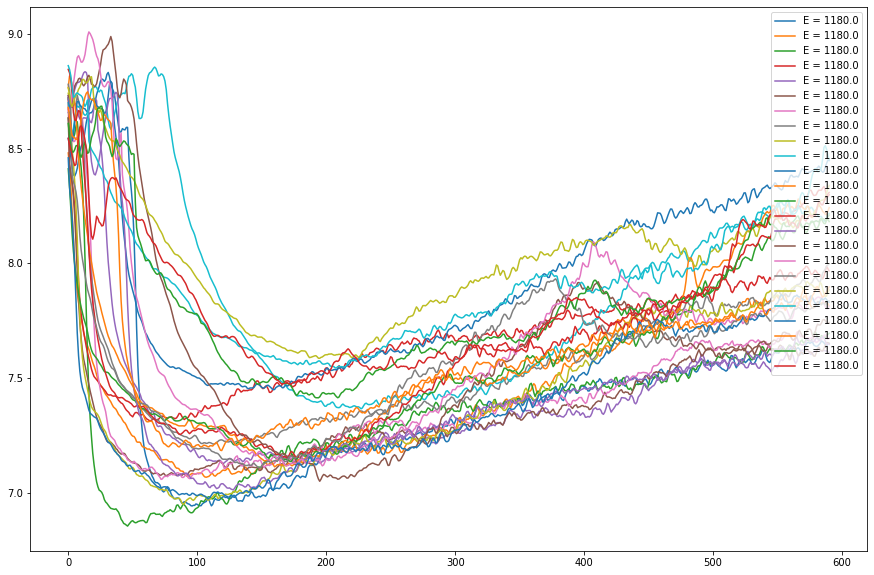

In [23]:
M_spec_bw_exp = np.zeros((len(data_features_exp[all_cle_exp[0]]['spectral_bandwidth'][0]),len(data_experience.keys())))
i=0
for cle in all_cle_exp:
    M_spec_bw_exp[:,i] = data_features_exp[cle]['spectral_bandwidth'][0]
    i+=1

plt.figure()
c = plt.imshow(M_spec_bw_exp[debut:fin,:],extent =[x_axis_exp.min(), x_axis_exp.max(), t_exp.min(), t_exp.max()],aspect='auto')
plt.colorbar(c)



plt.figure(figsize = (15,10))
for k in range(M_exp.shape[1]):
    if x_axis_exp[k] == 1180:
        plt.plot(np.log(M_spec_bw_exp[debut:fin,k]), label = 'E = '+str(x_axis_exp[k]))
        plt.legend(loc="upper right")

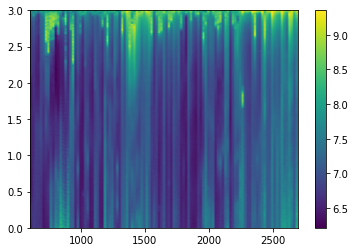

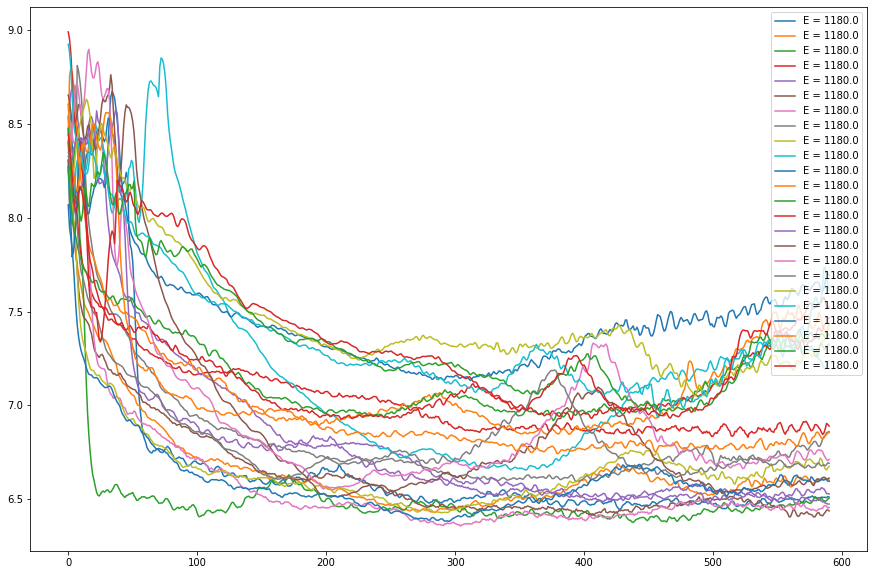

In [26]:
M_cent_exp = np.zeros((len(data_features_exp[all_cle_exp[0]]['spectral_centroid'][0]),len(data_experience.keys())))
i=0
for cle in all_cle_exp:
    M_cent_exp[:,i] = data_features_exp[cle]['spectral_centroid'][0]
    i+=1
    
plt.figure()
c = plt.imshow(np.log(M_cent_exp[debut:fin,:]),extent =[x_axis_exp.min(), x_axis_exp.max(), t_exp.min(), t_exp.max()],aspect='auto')
plt.colorbar(c)

plt.figure(figsize = (15,10))
for k in range(M_exp.shape[1]):
    if x_axis_exp[k] == 1180:
        plt.plot(np.log(M_cent_exp[debut:fin,k]), label = 'E = '+str(x_axis_exp[k]))
        plt.legend(loc="upper right")

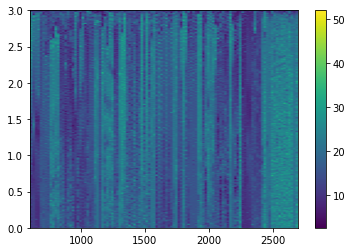

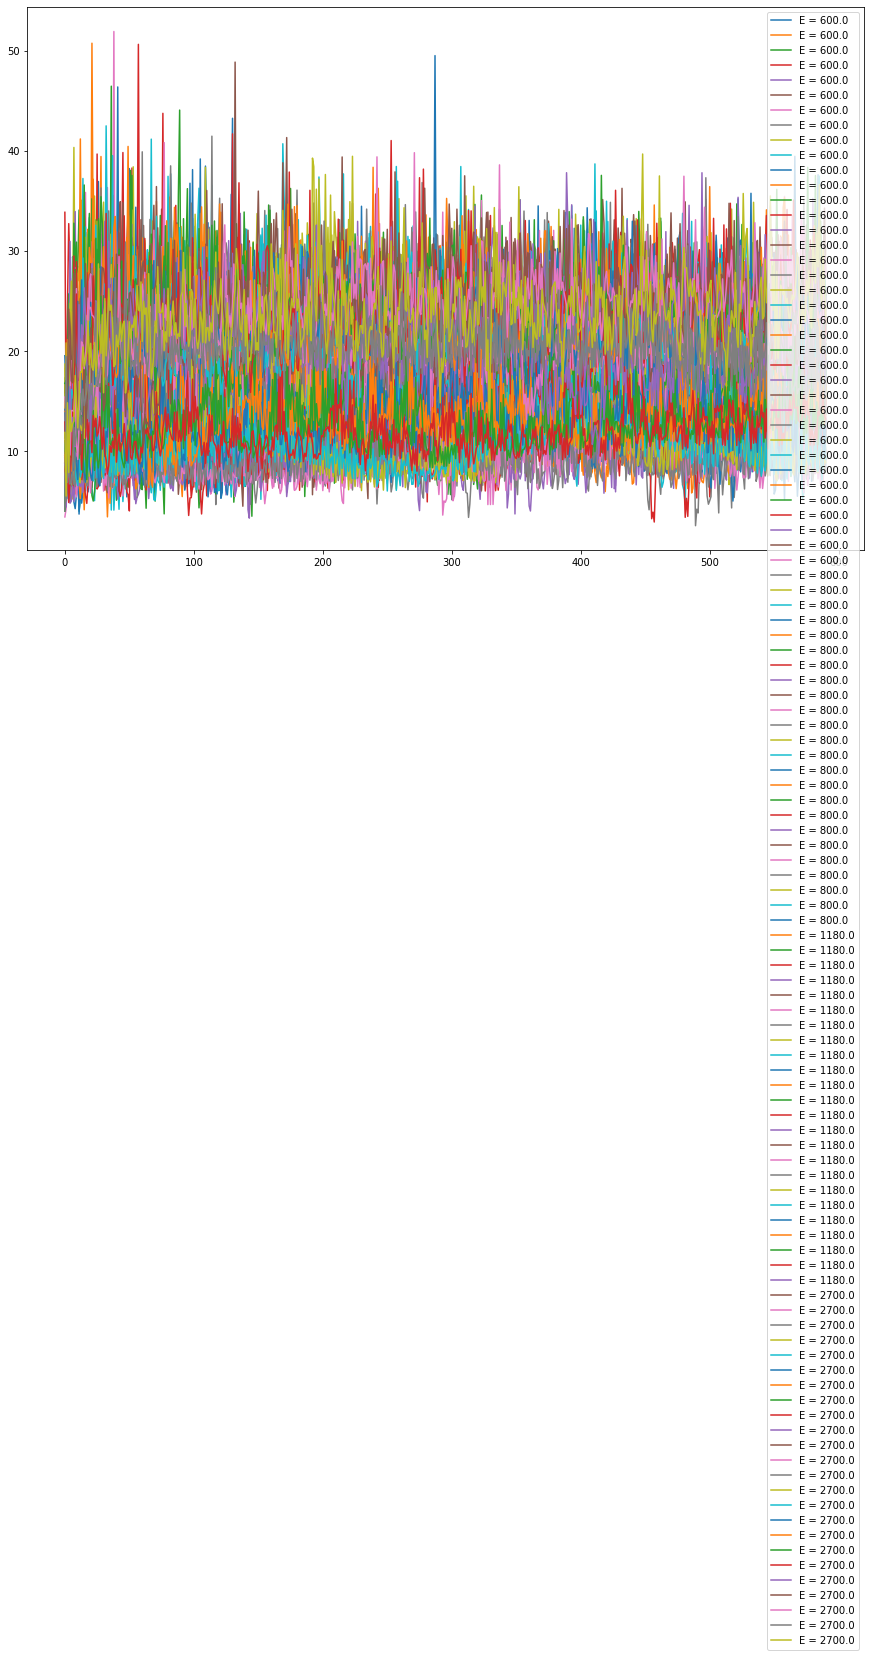

In [27]:
M_contrast_exp = np.zeros((len(data_features_exp[all_cle_exp[0]]['spectral_contrast'][0]),len(data_experience.keys())))
i=0
for cle in all_cle_exp:
    M_contrast_exp[:,i] = data_features_exp[cle]['spectral_contrast'][0]
    i+=1
    
plt.figure()
c = plt.imshow(M_contrast_exp[debut:fin,:],extent =[x_axis_exp.min(), x_axis_exp.max(), t_exp.min(), t_exp.max()],aspect='auto')
plt.colorbar(c)

plt.figure(figsize = (15,10))
for k in range(M_exp.shape[1]):

        plt.plot(M_contrast_exp[debut:fin,k], label = 'E = '+str(x_axis_exp[k]))
        plt.legend(loc="upper right")

"\nfor i in range(3):\n    for j in range(2):\n        ax[i,j].set_xscale('log')\n"

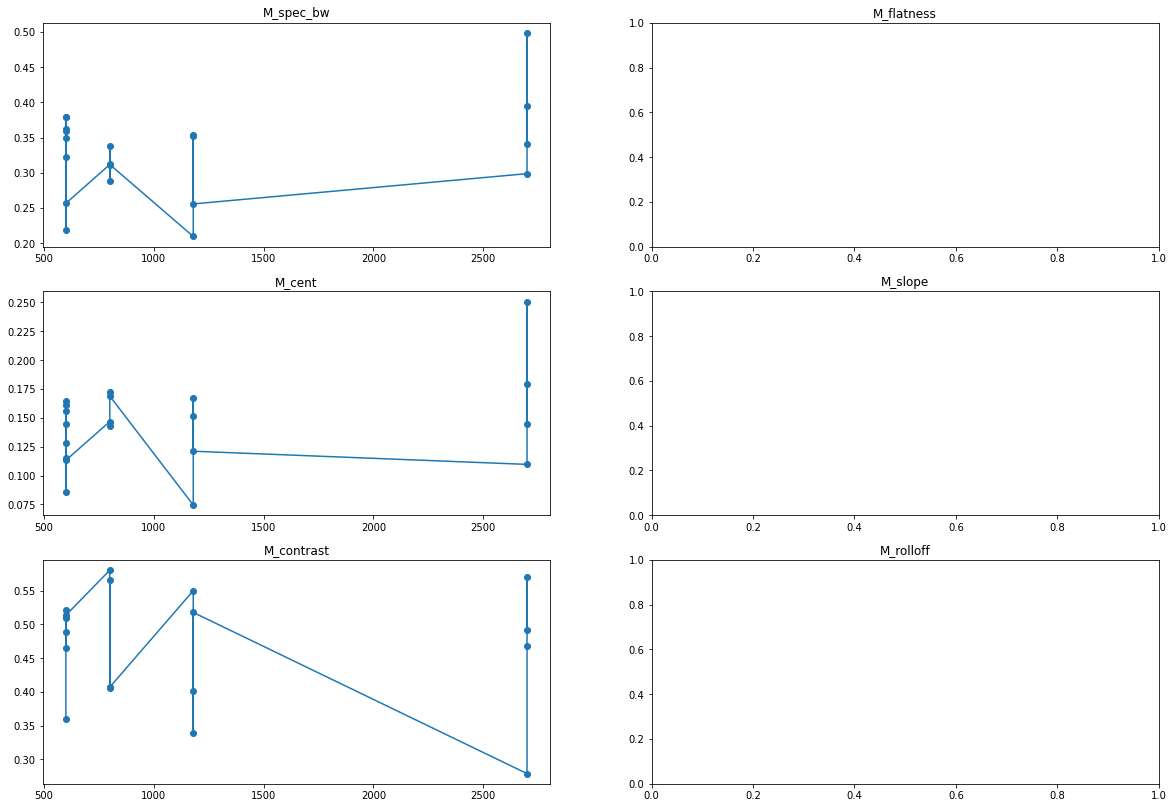

In [28]:
fig, ax = plt.subplots(3,2, figsize=(20,14))
ax[0,0].plot(x_axis_exp[np.where(corde_numero_exp==3)],np.mean(M_spec_bw_exp[debut:fin,np.where(corde_numero_exp==3)[0]] /np.max(np.abs(M_spec_bw_exp[:,np.where(corde_numero_exp==3)[0]])), axis=0),'o-')
ax[1,0].plot(x_axis_exp[np.where(corde_numero_exp==3)],np.mean(M_cent_exp[debut:fin,np.where(corde_numero_exp==3)[0]] /np.max(np.abs(M_cent_exp[:,np.where(corde_numero_exp==3)[0]])), axis=0),'o-')
ax[2,0].plot(x_axis_exp[np.where(corde_numero_exp==3)],np.mean(M_contrast_exp[debut:fin,np.where(corde_numero_exp==3)[0]] /np.max(np.abs(M_contrast_exp[:,np.where(corde_numero_exp==3)[0]])), axis=0),'o-')
'''
ax[0,1].plot(x_axis,np.mean(M_flatness[debut:fin,:] /np.max(np.abs(M_flatness[debut:fin,:])), axis=0),'o-')
ax[1,1].plot(x_axis,np.mean(M_slope[debut:fin,:] /np.max(np.abs(M_slope[debut:fin,:])), axis=0),'o-')
ax[2,1].plot(x_axis,np.mean(M_rolloff[debut:fin,:] /np.max(np.abs(M_rolloff[debut:fin,:])), axis=0),'o-')
'''

ax[0,0].set_title("M_spec_bw")
ax[1,0].set_title("M_cent")
ax[2,0].set_title("M_contrast")
ax[0,1].set_title("M_flatness") 
ax[1,1].set_title("M_slope")
ax[2,1].set_title("M_rolloff")

'''
for i in range(3):
    for j in range(2):
        ax[i,j].set_xscale('log')
'''